# Segmentation

Customer segmentation is the process of organising our customers into meaningful groups. Typically, we want individuals within each group to be very similar and people in different groups to be dissimilar. Segmentation is an important part of customer analysis because it allows us to understand the patterns that separate different customer groups. The insights can then be used to target specific customer groups.

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

import plotly.express as px

sns.set()

C:\Users\omar\Miniconda3\envs\ca\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_histogram(df: pd.DataFrame, feature_name: str, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    sns.countplot(df[feature_name], ax=ax)
    N = len(df[feature_name])
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/N), (x.mean(), y), ha='center', va='bottom')

def plot_correlation_map(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.heatmap(
        df.corr(), annot=True, fmt='0.2f', vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200), square=True, ax=ax
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
def plot_elbow_using_kmeans(data, k_range=(2, 14), metric='distortion'):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks(range(*k_range));
    model = KMeans(init='k-means++', random_state=42)
    visualizer = KElbowVisualizer(model, k=k_range, metric=metric, ax=ax)
    visualizer.fit(data)
    visualizer.show();

## Data

The dataset is provided by 365 Data Science Customer Analytics course. It consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical FMCG store. We can view the data as a sample that is representative of the whole country. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed and there are no missing values. In addition, the volume of the dataset has been restricted and anonymised to protect the privacy of the customers. 

In [3]:
df_data = pd.read_csv('data/fmcg-store-customers.csv', index_col=0)

In [4]:
df_data.head()

Sex  Marital status  Age  Education  Income  Occupation  \
ID                                                                   
100000001    0               0   67          2  124670           1   
100000002    1               1   22          1  150773           1   
100000003    0               0   49          1   89210           0   
100000004    0               0   45          1  171565           1   
100000005    0               0   53          1  149031           1   

           Settlement size  
ID                          
100000001                2  
100000002                2  
100000003                0  
100000004                1  
100000005                1

The data consists of demographic and geographical variables:

| Variable        | Data type   | Range     | Description                                                                                                                                                   |   |
|-----------------|-------------|-----------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|---|
| ID              | numerical   | Integer   | Shows a unique identificator of a customer.                                                                                                                   |   |
| Sex             | categorical | {0,1}     | Biological sex (gender)   of a customer. In this dataset there are only 2 different options. 0 = Male,   1=Female                                             |   |
| Marital status  | categorical | {0,1}     | Marital status of a   customer. 0=Single, 1=non-single (divorced / separated / married / widowed)                                                             |   |
| Age             | numerical   | Integer   | The age of the customer   in years, calculated as current year minus the year of birth of the customer   at the time of creation of the dataset               |   |
| Education       | categorical | {0,1,2,3} | Level of education of the   customer. 0=other/unknown, 1=high school, 2=university, 3=graduate   school                                                       |   |
| Income          | numerical   | Real      | Self-reported annual income in US dollars of the customer.                                                                                                    |   |
| Occupation      | categorical | {0,1,2}   | Category of occupation of   the customer. 0=unemployed/unskilled, 1=skilled employee/official,   2=management/self-employed/highly qualified employee/officer |   |
| Settlement size | categorical | {0,1,2}   | The size of the city that the customer lives in. 0=small,   1=mid-sized, 2=big                                                                                |   |

In [5]:
numerical_features = ['Age', 'Income']
categorical_features = ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']

## Feature Exploration

We know that the data is is preprocessed and there are no missing values.

### Gender

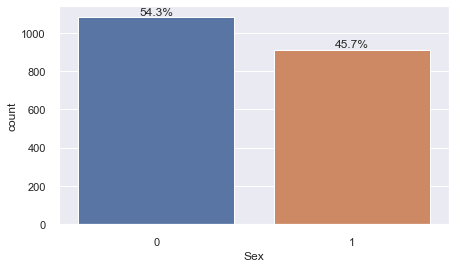

In [6]:
plot_histogram(df_data, 'Sex')

### Marital Status

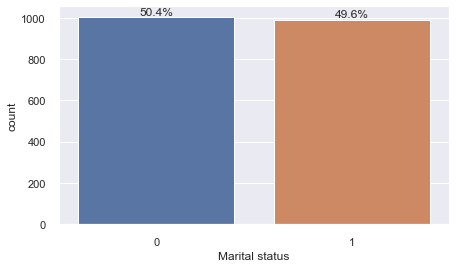

In [7]:
plot_histogram(df_data, 'Marital status')

### Education

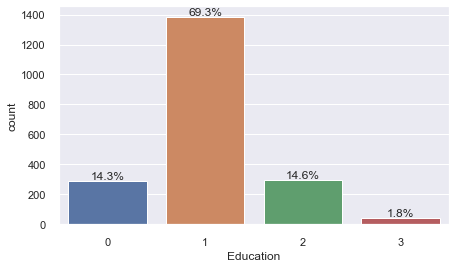

In [8]:
# 0=other/unknown, 1=high school, 2=university, 3=graduate school
plot_histogram(df_data, 'Education')

### Occupation

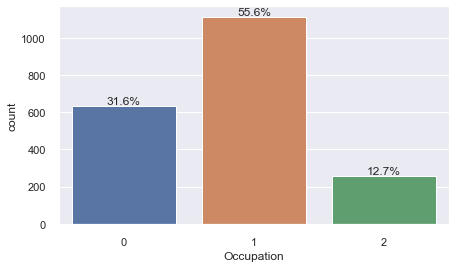

In [9]:
# 0=unemployed/unskilled, 
# 1=skilled employee/official, 
# 2=management/self-employed/highly qualified employee/officer
plot_histogram(df_data, 'Occupation')

### Settlement Size

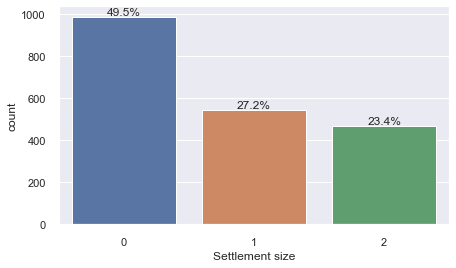

In [10]:
#  0=small city, 1=mid-sized city, 2=big city
plot_histogram(df_data, 'Settlement size')

### Age

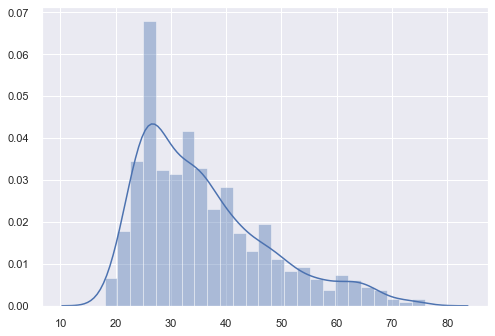

In [11]:
sns.distplot(df_data[['Age']]);

### Income

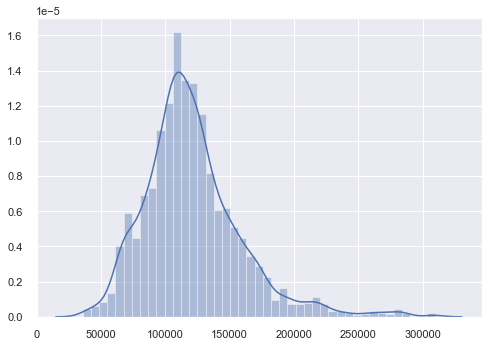

In [12]:
sns.distplot(df_data[['Income']]);

## Pairs of Features

### Correlation

Correlation help us understand the linear relationships between the pairs of features.

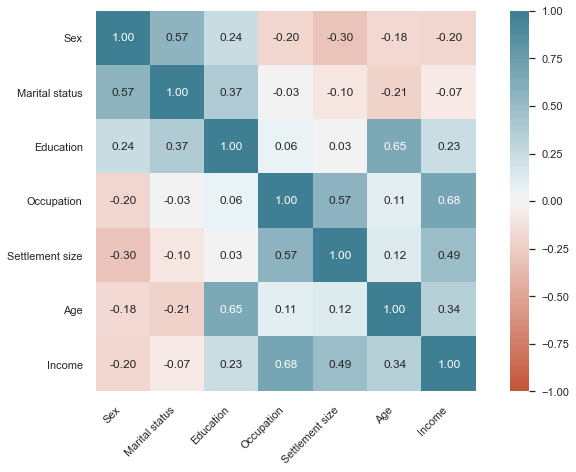

In [13]:
plot_correlation_map(df_data[categorical_features + numerical_features])

- Positive correlation between Income and Occupation. We can expect managers to earn more than unskilled employees.
- Positive correlation between Education and Age. This makes some sense. We do not expect 18 years to have a university degree.
- Interesting correlation between Marital status and Gender.

### Age and Income

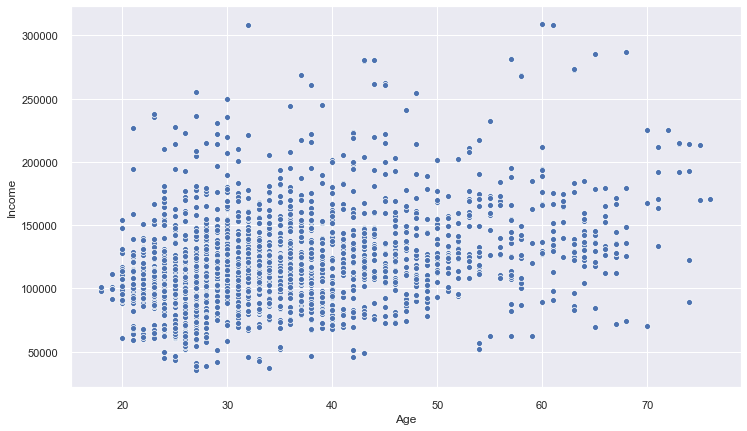

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(x='Age', y='Income', data=df_data, ax=ax);

## Clustering

In unsupervised learning, clustering is the task of grouping related data points using a clustering algorithm. There are a variety of algorithms:
- Hierarchical Clustering:
- k-Means: group data points based on their proximity to a centroid. Simple to understand and relatively fast.

Typically, we review the clustering results of an algorithm and assign a meaningful label to each group.

In general there are two types of metrics that we can use to evaluate the results of a clustering algorithm:
- Extrinsic: when we ground truth we can use Adjusted Rand Index, Fowlkes-Mallows, Mutual Information-based scores, Homogeneity, Completeness and V-measure.
- Intrinsic: When the ground truth labels are unknown, we can use Silhouette Coefficient, Calinski-Harabasz Index, Davies-Bouldin Index,  Cophenetic Correlation Coefficient (for hierarchical clustering)

Prepare the data for clustering

In [15]:
# Perform standardisation of the data so each feature have the same scale
X_feature_names = categorical_features + numerical_features
pickle.dump(X_feature_names, open('models/feature-names.pickle', 'wb'))

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(df_data[X_feature_names])

In [17]:
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

In [18]:
# Store the 2D data in the DataFrame for later use.
df_data['tSNE_Dim1'] = X_2d[:,0]
df_data['tSNE_Dim2'] = X_2d[:,1]

Generate an interactive plot of the 2D data using Plotly.

In [19]:
df_data['Gender'] = df_data['Sex'].map(lambda val: 'Male' if val == 0 else 'Female')

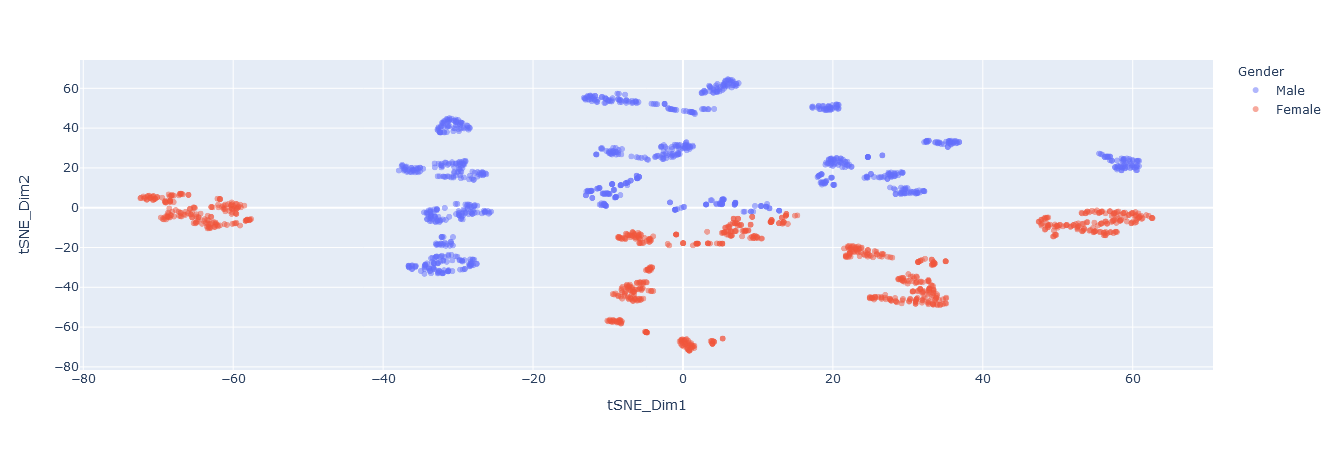

In [20]:
fig = px.scatter(df_data, x='tSNE_Dim1', y='tSNE_Dim2', color='Gender', opacity=.5, 
                 hover_data=numerical_features+categorical_features)
fig.show()

Plot 2D data.

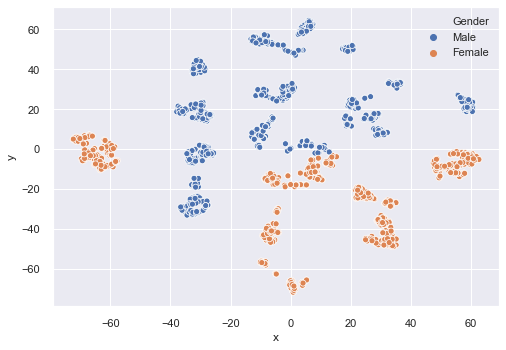

In [21]:
ax = sns.scatterplot(x='tSNE_Dim1', y='tSNE_Dim2', hue='Gender', data=df_data);
ax.set_xlabel('x')
ax.set_ylabel('y');

### Hierarchical Clustering

Two types of hierarchical clustering:
- Divisive (top down): Initially, all samples belong to one cluster. The big cluster is split into two smaller clusters. We keep splitting the clusters until each sample is a separate cluster. To find the best split, we must consider explore all possible splits at each step.
- Agglomerative (bottom up): Initially, each sample belong to their own cluster. At each step, we combine clusters together until we reach one big cluster. Usually, preferred over divisive because it is easier to solve mathematically.

There are different distance measures used in hierarchical clustering:
- Single Link: distance between the closest data points in clusters. Tend to produce long chains
- Complete Link: distance between the farthest data points in clusters. Tend to produce "spherical" clusters of roughly same size
- Average Link: the average of all pairwise distances. It is less affected by outliers.
- Ward's method: minimise the cluster variances after each merge

Since the number of samples is limited, we will use hierarchical clustering because it can automatically find the number of clusters in the data. This is useful when we have no prior knowledge of number of clusters. However, it is inefficient and the computation time would be much longer if the data size was larger. In such cases, we can use flat clustering methods such as k-means. In some cases, it makes sense to perform hierarchical clustering to determine clusters and then apply flat clustering for segmentation.

Let us compare different distance measures in hierarchical clustering algorithms. For this, we use the cophenetic correlation to evaluate the different methods. 

> The cophenetic correlation for a cluster tree is defined as the linear correlation coefficient between the cophenetic distances obtained from the tree, and the original distances (or dissimilarities) used to construct the tree. Thus, it is a measure of how faithfully the tree represents the dissimilarities among observations.
> 
> The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.
> 
> The output value, c, is the cophenetic correlation coefficient ranges from 1 to -1. The magnitude of this value should be very close to 1 for a high-quality solution. This measure can be used to compare alternative cluster solutions obtained using different algorithms.
> [From MathWorks](https://se.mathworks.com/help/stats/cophenet.html)


In [22]:
distance_methods = ['single', 'complete', 'average', 'ward']

# Compute pairwise distances between data points because it is
# needed by the `cophenet` function
pairwise_dist = pdist(X, metric='euclidean')

for distance_method in distance_methods:
    cpc, _ = cophenet(linkage(X, method=distance_method), pairwise_dist)
    print(f'Cophenetic Correlation for {distance_method}: {cpc:.3f}')

Cophenetic Correlation for single: 0.578
Cophenetic Correlation for complete: 0.487
Cophenetic Correlation for average: 0.734
Cophenetic Correlation for ward: 0.599


It seems that the average distance linkage performs the best on our data.

In [23]:
linkage_matrix = linkage(X, method='average')

Let us plot a dendogram which is a tree-like hierarchical structure for representating the clusters.

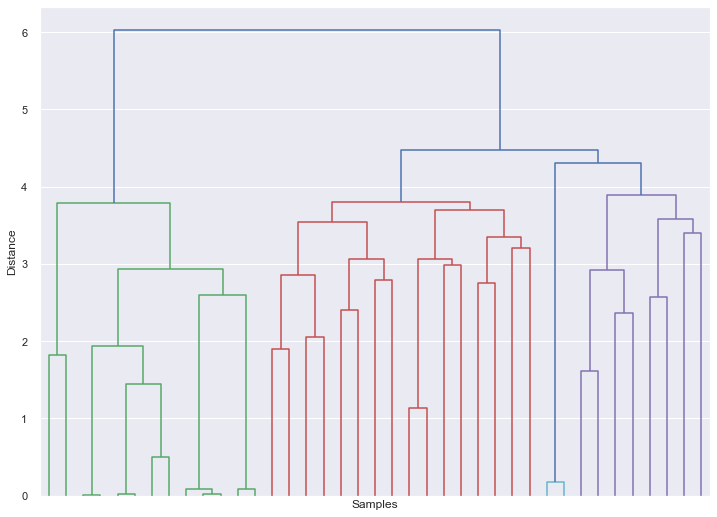

In [24]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlabel('Samples')
ax.set_ylabel('Distance')

dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=False, no_labels=True, ax=ax);

The `linkage` function found four clusters automatically. 

> If we had to find the clusters ourselves, we would have to find a horisontal line in the dendogram in which to cut. 
One heuristic is to find the longest vertical line which is not intercepted by a horizontal line in the dendrogram.

In [25]:
# Compute the cluster assignments
hier_cluster_results = fcluster(linkage_matrix, t=4, criterion='maxclust')

In [26]:
df_data['SegmentHierAvgLink'] = hier_cluster_results
df_data['SegmentHierAvgLink'] = df_data['SegmentHierAvgLink'].astype('category')

In [27]:
df_data.groupby('SegmentHierAvgLink').count()[['Age']].T

SegmentHierAvgLink   1     2  3    4
Age                 17  1765  2  216

Interestingly, the clustering results does not seem to be good. The majority of customers ended up in cluster 2 and in cluster 3 there are only two customers. Let us visualise the results via t-SNE.

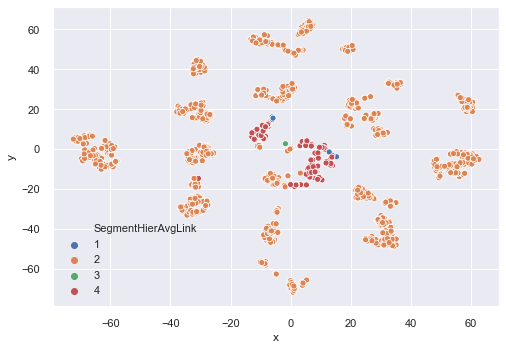

In [28]:
ax = sns.scatterplot(x='tSNE_Dim1', y='tSNE_Dim2', hue='SegmentHierAvgLink', data=df_data);
ax.set_xlabel('x')
ax.set_ylabel('y');

Let us try the Ward method.

In [29]:
linkage_matrix = linkage(X, method='ward')

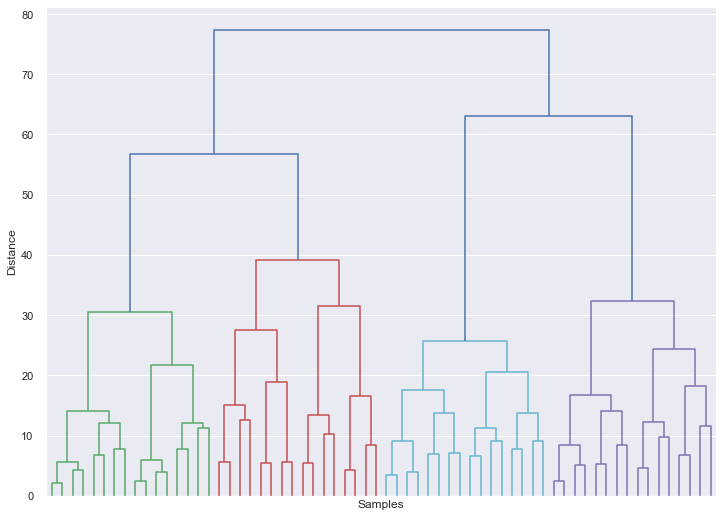

In [30]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlabel('Samples')
ax.set_ylabel('Distance')

dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=False, no_labels=True, ax=ax);

In [31]:
hier_cluster_results = fcluster(linkage_matrix, t=4, criterion='maxclust')
df_data['SegmentHierWardLink'] = hier_cluster_results
df_data['SegmentHierWardLink'] = df_data['SegmentHierWardLink'].astype('category')
df_data.groupby('SegmentHierWardLink').count()[['Age']].T

SegmentHierWardLink    1    2    3    4
Age                  531  649  241  579

The Ward's method seems to produce four roughly same-sized groups.

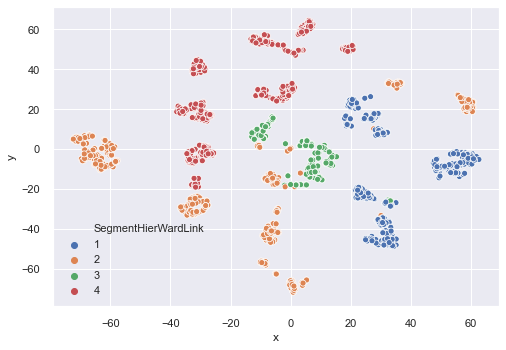

In [32]:
ax = sns.scatterplot(x='tSNE_Dim1', y='tSNE_Dim2', hue='SegmentHierWardLink', data=df_data);
ax.set_xlabel('x')
ax.set_ylabel('y');

In [33]:
df_data_hwl = df_data.groupby(['SegmentHierWardLink']).mean()[numerical_features+categorical_features]
df_data_hwl['N'] = df_data[['SegmentHierWardLink', 'Age']].groupby(['SegmentHierWardLink']).count()
df_data_hwl['Proportion'] = df_data_hwl['N'] / df_data_hwl['N'].sum()

In [34]:
df_data_hwl

Age         Income       Sex  Marital status  \
SegmentHierWardLink                                                       
1                    28.062147  120399.591337  0.711864        1.000000   
2                    34.583975   90807.328197  0.640986        0.445300   
3                    54.593361  163924.684647  0.497925        0.717842   
4                    36.813472  137369.343696  0.000000        0.000000   

                     Education  Occupation  Settlement size    N  Proportion  
SegmentHierWardLink                                                           
1                     1.000000    1.075330         0.843691  531      0.2655  
2                     0.992296    0.101695         0.023112  649      0.3245  
3                     2.120332    1.257261         1.219917  241      0.1205  
4                     0.673575    1.176166         1.245250  579      0.2895

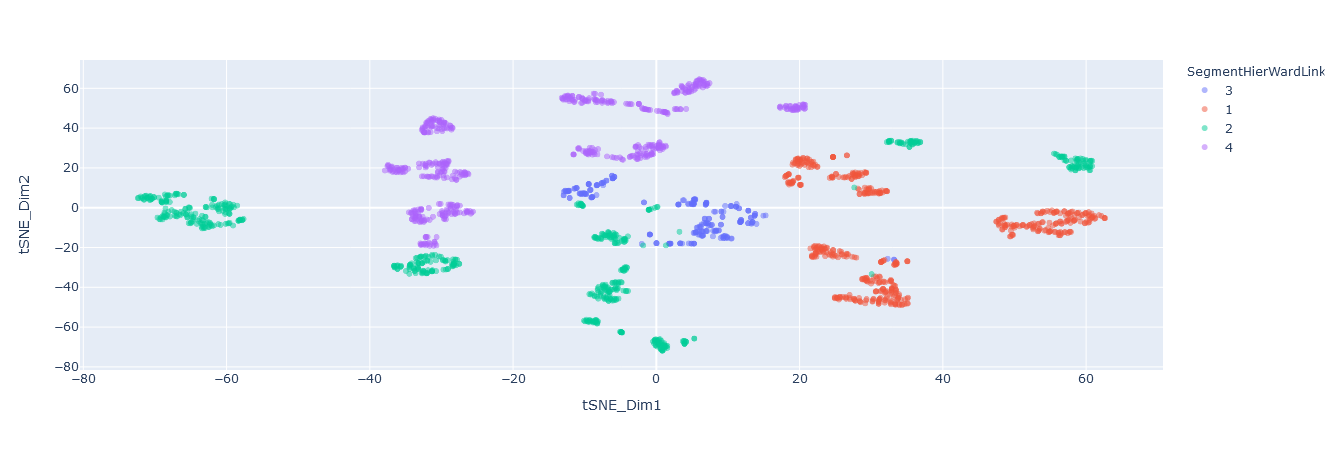

In [35]:
fig = px.scatter(df_data, x='tSNE_Dim1', y='tSNE_Dim2', color='SegmentHierWardLink', opacity=.5, 
                 hover_data=numerical_features+categorical_features)
fig.show()

### k-Means

There is a few issues with k-Means:
- $k$ or the number of cluster is a hyperparameter that we must specify beforehand. If $k$ is too small, the centroids may not lie inside the clusters. If it is too large, some of the clusters may be split into two. There are several ways to pick $k$:
  - Prior knowledge
  - Elbow method
- The squared Euclidian distance is sensitive to outliers. Usually, points that are two far away from the rest of samples will become a cluster of their own. To avoid this, we can use k-Medians clustering. However, k-Medians is more computationally expensive.
- Does not work well when clusters do not have spherical shapes.
- Some data points may end up in different clusters depending on locations of the initial centroids.

Usually, k-means yields good segmentation results because the groups of samples have spherical shape.

### Elbow Method

There are a number of ways to estimate the number of clusters to pick. One common approach is to compute a "quality" metric for different values of $k$, then plot the results as a line chart in order to visually determine a good value for $k$. Typically, the line chart looks like an arm or a leg. The point of inflection in the line is known as the elbow or the knee. A strong bending in the line chart gives a indication that the corresponding $k$ is an appropriate hyperparameter for the model. Increasing $k$ further no longer decrease the metric substantially. This point is known as the elbow.

One metric is to calculate the Within-Cluster-Sum-of-Squares (WCSS) for different values of $k$ and plot them to find the elbow. 

\begin{align}
WCSS(k) = \sum_{j=1}^{k} \sum_{\mathbf{x}_i \in \mathcal{C}(j)} \lVert \mathbf{x}_i - \mathbf{c}_j \rVert^2
\end{align}

where:
- $k$ is the number of clusters
- $\mathcal{C}(j)$ is the set of samples in cluster $j$
- $\mathbf{c}_j$ is the centroid of cluster $j$

The WCSS measures the compactness of all the clusters. A low value indicates high degree of overall compactness.

We start at $k=2$ because $k=1$ means that all the samples are in one big cluster.

In [36]:
clusters_range = (2, 14)

In [37]:
wcss = []
for k in range(*clusters_range):
    # k-means++ initialisation attempts to find a good set of centroids
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    # Inertia is the sum of squared distances of samples to their closest centroid.
    wcss.append(kmeans.inertia_)

Once WCSS values are computed, we can plot them and determine a good enough $k$.

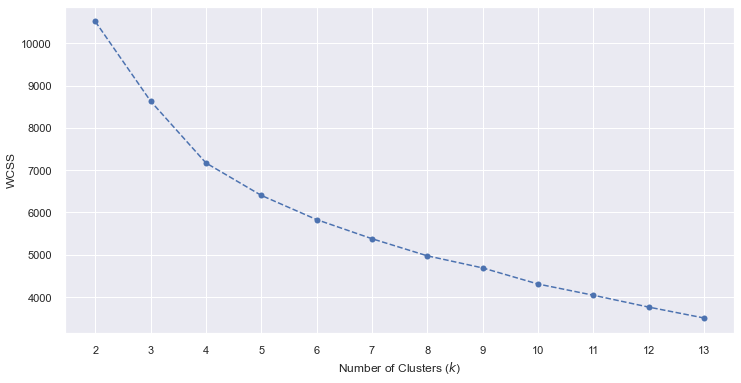

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(*clusters_range), wcss, marker='o', linestyle='--')
ax.set_xlabel('Number of Clusters ($k$)')
ax.set_ylabel('WCSS')
ax.set_xticks(range(*clusters_range));

By eyeballing the figure, we see that the drops from 2 to 3, 3 to 4 are relatively large. But then drops are not as large. It seems a value of $k$ of 4 or 5 is good.

Alternatively, we can use yellowbricks' `KElbowVisualizer` which implements the Elbow method with nice visualisation.

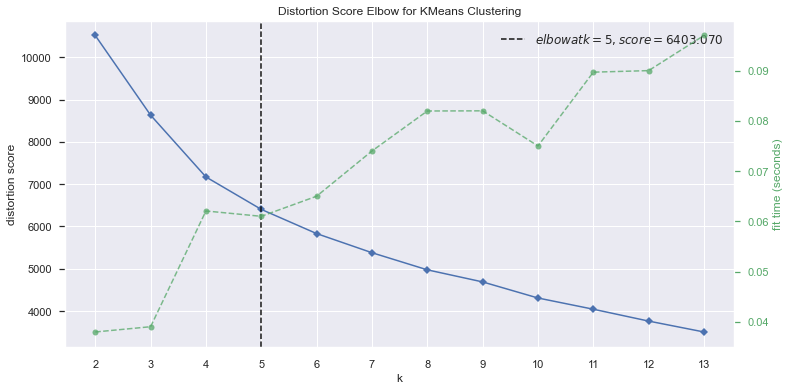

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks(range(*clusters_range));
model = KMeans(init='k-means++', random_state=42)
visualizer = KElbowVisualizer(model, k=clusters_range, ax=ax)
visualizer.fit(X)
visualizer.show();

The distortion score computes the sum of squared distances from each point to its assigned centroid. It is just one heuristic.

Another heuristic is Calinski-Harabasz. It is used to compare clustering results on the same data by changing either the number of clusters or by the clustering method. As in the WCSS and distortion metrics, these heuristics are used to estimate the number of clusters in the data. 

C:\Users\omar\Miniconda3\envs\ca\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning:

No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.

C:\Users\omar\Miniconda3\envs\ca\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

C:\Users\omar\Miniconda3\envs\ca\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



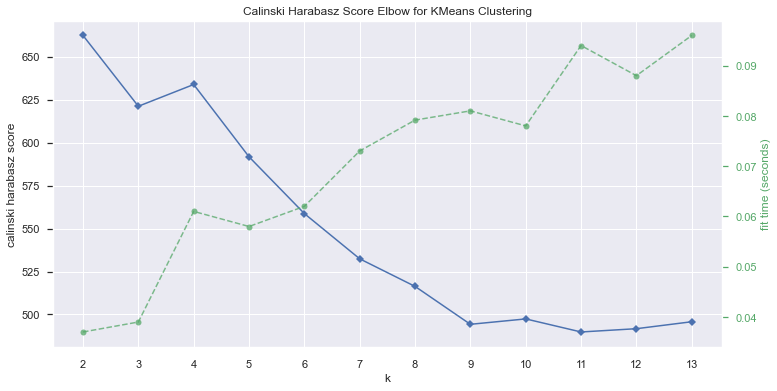

In [40]:
plot_elbow_using_kmeans(X, k_range=clusters_range, metric='calinski_harabasz')

There is no clear knee point in the data. If we go after the higher the value, the "better" is the solution, we would pick $k=2$ or perhaps $k=4$.

The mean silhouette coefficient for all samples

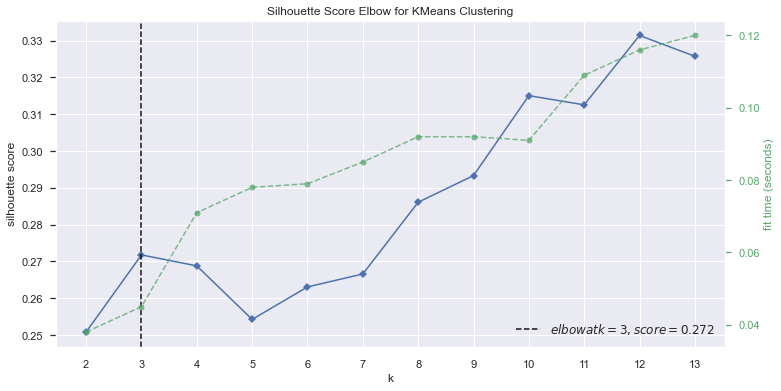

In [41]:
plot_elbow_using_kmeans(X, k_range=clusters_range, metric='silhouette')

From all these metrics, we have a rough idea that the number of clusters is between 3 and 5.

## Cluster Interpretation

Let us use $k=4$ and explore the four segments.

In [42]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [43]:
df_data_segmented = df_data[numerical_features + categorical_features].copy()
df_data_segmented['Segment'] = kmeans.labels_

In [44]:
df_grouped = df_data_segmented.groupby(['Segment']).mean()
df_grouped['N'] = df_data_segmented[['Segment', 'Age']].groupby(['Segment']).count()
df_grouped['Proportion'] = df_grouped['N'] / df_grouped['N'].sum()

In [45]:
df_grouped

Age         Income       Sex  Marital status  Education  \
Segment                                                                  
0        55.703422  158338.422053  0.501901        0.692015   2.129278   
1        35.577922   97859.852814  0.352814        0.019481   0.746753   
2        35.635088  141218.249123  0.029825        0.173684   0.733333   
3        28.963121  105759.119149  0.853901        0.997163   1.068085   

         Occupation  Settlement size    N  Proportion  
Segment                                                
0          1.129278         1.110266  263      0.1315  
1          0.329004         0.043290  462      0.2310  
2          1.271930         1.522807  570      0.2850  
3          0.634043         0.422695  705      0.3525

- Segment 0: Avg. age of 56 (oldest segment). Highest average income. Most of them married. High education. Good jobs. We can refer to this group as "Well-Off"
- Segment 1: Avg. age of 36. Lowest avg. income. 2/3 are male. Almost all are single. Low end at education level. Lowest employment levels. Live exclusively in small cities. It seems this group encompases people with fewer opportunities. Label: "Fewer-Opportunities"
- Segment 2: Avg. age of 36. High avg. income. Entirely men. Less than 20% are in relationships. Low education. High jobs. Majority live in mid-sized and big cities. It appears they are career-focused. Label: Career-Focused
- Segment 3: Avg. age of 29 (youngest segment). Low avg. income. Mostly female. All in relationships. Moderate education. Middle management jobs. Equally distributed between small, mid-sized and big cities. They seem average in parameter. Label: "Standard"

In [46]:
# Rename the segments
segment_labels = {
    0: 'well-off',
    1: 'fewer-opportunities',
    2: 'career-focused',
    3: 'standard',
}

pickle.dump(segment_labels, open('models/segment-labels.pickle', 'wb'))

# Create a new column where the segment numbers are mapped to the segment labels.
df_data_segmented['SegmentLabel'] = df_data_segmented['Segment'].map(segment_labels)

# Store segmented data for later use.
df_data_segmented.to_csv('data/fmcg-store-segmented-customers.csv')

In [47]:
df_grouped.rename(segment_labels)

Age         Income       Sex  Marital status  \
Segment                                                                   
well-off             55.703422  158338.422053  0.501901        0.692015   
fewer-opportunities  35.577922   97859.852814  0.352814        0.019481   
career-focused       35.635088  141218.249123  0.029825        0.173684   
standard             28.963121  105759.119149  0.853901        0.997163   

                     Education  Occupation  Settlement size    N  Proportion  
Segment                                                                       
well-off              2.129278    1.129278         1.110266  263      0.1315  
fewer-opportunities   0.746753    0.329004         0.043290  462      0.2310  
career-focused        0.733333    1.271930         1.522807  570      0.2850  
standard              1.068085    0.634043         0.422695  705      0.3525

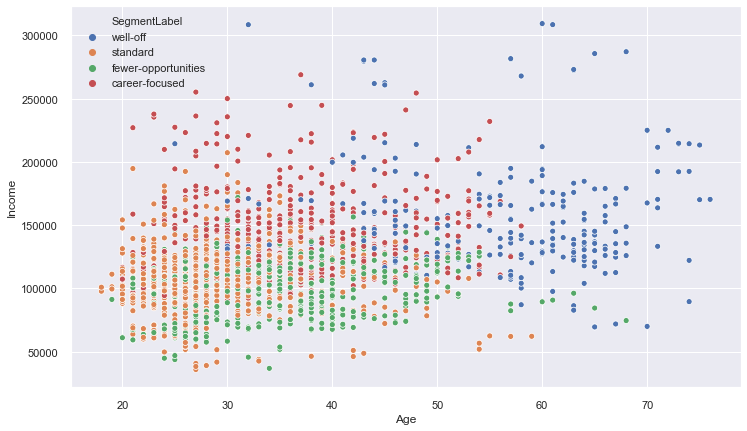

In [48]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(x='Age', y='Income', hue='SegmentLabel', data=df_data_segmented, ax=ax);

## Principal Component Analysis

In [49]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
evrcs = pca.explained_variance_ratio_.cumsum()
evrcs

array([0.35696328, 0.61947251, 0.80768365, 0.88326115, 0.94042627,
       0.97997421, 1.        ])

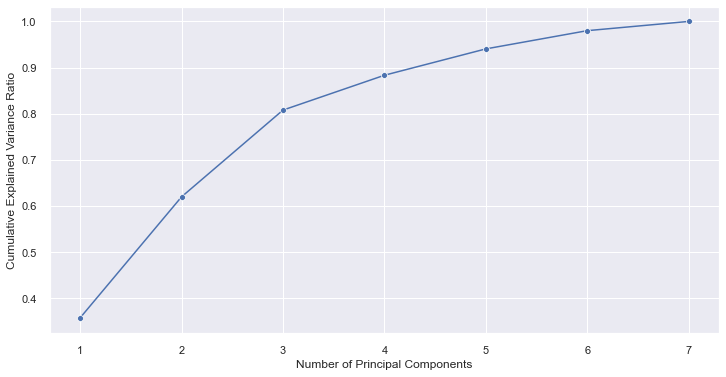

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
x_vals = range(1, len(evrcs)+1)
sns.lineplot(x=x_vals, y=evrcs, marker='o', ax=ax)
ax.set_xticks(x_vals)
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Variance Ratio');

At least 90% of the variance in the data is explained by five PCs. If we use 3 PCs, we preserve around 80% of the information.

In [52]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [53]:
df_pca = pd.DataFrame(data=pca.components_, columns=X_feature_names, index=['PC1', 'PC2', 'PC3'])

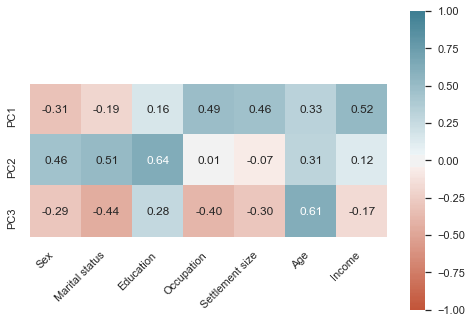

In [54]:
ax = sns.heatmap(
    df_pca, annot=True, fmt='0.2f', vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

- PC1 is positively correlated with Education, Occupation, Settlement Size, Age and Income. Interestingly, these variables relate to the career of a person.
- PC2 is positively correlated with Sex, Marital status, Education and Age. This could be interpreted as individuals education and life-style.
- PC3: Age, Martial Status and Occupation are the most important determinants. Interpreted as life/work experience.

In [55]:
X_3d = pca.transform(X)

## k-Means on PCA Data

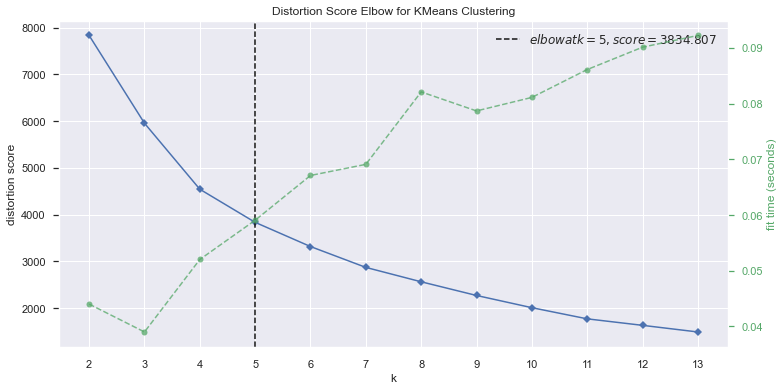

In [56]:
plot_elbow_using_kmeans(X_3d)

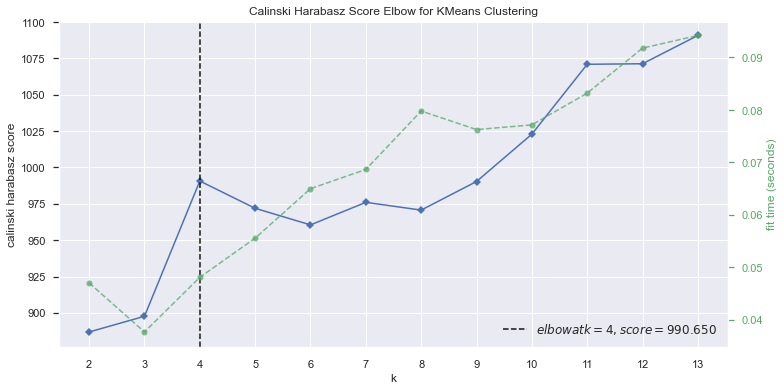

In [57]:
plot_elbow_using_kmeans(X_3d, k_range=clusters_range, metric='calinski_harabasz')

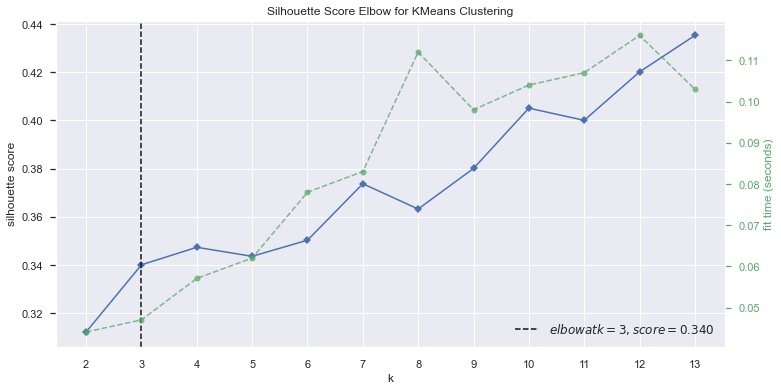

In [58]:
plot_elbow_using_kmeans(X_3d, k_range=clusters_range, metric='silhouette')

Again, we pick 4 clusters.

In [59]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(X_3d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [60]:
df_data_3d = pd.DataFrame(data=X_3d, columns=['PC1', 'PC2', 'PC3'])

In [61]:
df_data_3d['Label'] = model.labels_
df_data_3d['Label'] = df_data_3d['Label'].astype('category')

In [62]:
fig = px.scatter_3d(df_data_3d, x='PC1', y='PC2', z='PC3', color='Label')
fig.show()

In [63]:
# Save the models
pickle.dump(scaler, open('models/segmentation-scaler.pickle', 'wb'))
pickle.dump(pca, open('models/segmentation-pca.pickle', 'wb'))
pickle.dump(model, open('models/segmentation-kmeans-pca.pickle', 'wb'))